Data science with Mordred Library

---

In [34]:
import os
import pubchempy as pcp

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from mordred import Calculator
from mordred.MoeType import SlogP_VSA
from mordred.HydrogenBond import HBondDonor, HBondAcceptor
from mordred.RingCount import RingCount
from mordred.Weight import Weight
from mordred.SLogP import SLogP
from mordred.TopoPSA import TopoPSA

In [50]:

cs = pcp.get_compounds('Aspirin', 'name')
target = cs[0]
print(f"CID: {target.cid}")

props = pcp.get_properties(['CanonicalSMILES', 'IsomericSMILES'], target.cid, 'cid')

smiles = props[0].get('SMILES')
print(smiles)
similar = pcp.get_compounds(smiles, namespace='smiles', searchtype='similarity', Threshold=95, listkey_count=1000)


CID: 2244
CC(=O)OC1=CC=CC=C1C(=O)O


In [51]:
target_mol = Chem.MolFromSmiles(smiles)
generator = GetMorganGenerator(radius=2, fpSize=2048)
target_fp = generator.GetFingerprint(target_mol)

In [52]:

important_desc = [
    SlogP_VSA(k=2),  # SlogP_VSA2
    SlogP_VSA(k=8),  # SlogP_VSA8
    HBondDonor(),
    HBondAcceptor(),
    RingCount(),
    Weight(),
    SLogP(),
    TopoPSA()
]


records = list()
calc = Calculator(important_desc, ignore_3D=True)

In [81]:
try:
    for c in similar:
 #       similar_props = pcp.get_properties(['CanonicalSMILES', 'IsomericSMILES'], c.cid, 'cid')
  #      print(similar_props)

        similar_smiles = pcp.get_properties(['SMILES'],c.cid, 'cid')[0].get('SMILES')
#        similar_smiles = similar_props[0].get('SMILES')

        
        mol = Chem.MolFromSmiles(similar_smiles)

        if mol is None:
            print(f"[WARN] CID {c.cid}: Invalid SMILES skipped.")
            continue
        
        desc = calc(mol).asdict()

        generator = GetMorganGenerator(radius=2, fpSize=2048)
        fp = generator.GetFingerprint(mol)

        tanimoto = DataStructs.TanimotoSimilarity(target_fp, fp)



        desc["CID"] = c.cid
        desc["SMILES"] = similar_smiles
        desc["IUPAC"] = c.iupac_name
        desc["Tanimoto"] = tanimoto 
        print(desc)
        records.append(desc)
        print(f"[INFO] Processed CID {c.cid}")

except KeyError as e:
    print(f"{c.iupac_name} has no SMILES!!")

{'SlogP_VSA2': 17.045137970744406, 'SlogP_VSA8': 0.0, 'nHBDon': 1, 'nHBAcc': 3, 'nRing': 1, 'MW': 180.042258736, 'SLogP': 1.3101, 'TopoPSA(NO)': 63.60000000000001, 'CID': 2244, 'SMILES': 'CC(=O)OC1=CC=CC=C1C(=O)O', 'IUPAC': '2-acetyloxybenzoic acid', 'Tanimoto': 1.0}
[INFO] Processed CID 2244


KeyboardInterrupt: 

In [80]:

print(records)
df = pd.DataFrame(records)
print(df.info())
print(df.columns)

print(f"[INFO] Mordred descriptors calculated for {len(df)} compounds")
#print(df)

# Descriptor의 중요한 feature들 
desc_cols = ["SlogP_VSA2", "SlogP_VSA8", "nHBDon", "nHBAcc", "nRing", "MW", "SLogP", "TopoPSA(NO)", "Tanimoto"]

# 원본값 유지용 DataFrame
df_clean = df[desc_cols].apply(pd.to_numeric, errors='coerce').dropna()


[{'SlogP_VSA2': 17.045137970744406, 'SlogP_VSA8': 0.0, 'nHBDon': 1, 'nHBAcc': 3, 'nRing': 1, 'MW': 180.042258736, 'SLogP': 1.3101, 'TopoPSA(NO)': 63.60000000000001, 'CID': 2244, 'SMILES': 'CC(=O)OC1=CC=CC=C1C(=O)O', 'IUPAC': '2-acetyloxybenzoic acid', 'Tanimoto': 1.0}, {'SlogP_VSA2': 22.15166536558511, 'SlogP_VSA8': 0.0, 'nHBDon': 2, 'nHBAcc': 4, 'nRing': 2, 'MW': 258.0528234200001, 'SLogP': 2.3096, 'TopoPSA(NO)': 83.83000000000001, 'CID': 5161, 'SMILES': 'C1=CC=C(C(=C1)C(=O)OC2=CC=CC=C2C(=O)O)O', 'IUPAC': '2-(2-hydroxybenzoyl)oxybenzoic acid', 'Tanimoto': 0.59375}, {'SlogP_VSA2': 19.048408117181232, 'SlogP_VSA8': 0.0, 'nHBDon': 0, 'nHBAcc': 4, 'nRing': 1, 'MW': 194.0579088, 'SLogP': 1.3985, 'TopoPSA(NO)': 52.60000000000001, 'CID': 68484, 'SMILES': 'CC(=O)OC1=CC=CC=C1C(=O)OC', 'IUPAC': 'methyl 2-acetyloxybenzoate', 'Tanimoto': 0.6666666666666666}, {'SlogP_VSA2': 23.014443258696254, 'SlogP_VSA8': 0.0, 'nHBDon': 1, 'nHBAcc': 5, 'nRing': 2, 'MW': 300.0633881040003, 'SLogP': 2.5293, 'TopoP

In [71]:
ex = df[(df['Tanimoto'] >= 0.9) & (df['SLogP'] <= 0)]
ex.head()

,SlogP_VSA2,SlogP_VSA8,nHBDon,nHBAcc,nRing,MW,SLogP,TopoPSA(NO),CID,SMILES,IUPAC,Tanimoto
221,45.358587,0.0,1,3,1,243.044927,-0.7201,126.6,66584239,CC(=O)OC1=CC=CC=C1C(=O)O.O.O.[Al],None,0.923077
282,27.997522,0.0,1,3,1,216.063388,-0.3393,126.6,70184071,CC(=O)OC1=CC=CC=C1C(=O)O.O.O,2-acetyloxybenzoic acid;dihydrate,0.960000
311,17.045138,0.0,1,3,1,215.011660,-1.6859,63.6,86590972,CC(=O)OC1=CC=CC=C1C(=O)O.[Cl-],2-acetyloxybenzoic acid chloride,0.960000
481,17.045138,0.0,1,3,1,253.974818,-4.6819,63.6,161210106,CC(=O)OC1=CC=CC=C1C(=O)O.[Cl-].[K+],potassium;2-acetyloxybenzoic acid;chloride,0.923077
509,17.045138,0.0,1,3,1,204.039853,-1.5734,63.6,173010661,[H-].CC(=O)OC1=CC=CC=C1C(=O)O.[Na+],sodium;2-acetyloxybenzoic acid;hydride,0.923077


In [58]:

print(f"[INFO] Descriptor DataFrame shape: {df_clean.shape}")
print(df_clean)

print(df_clean.corr())
print(df_clean.info())


[INFO] Descriptor DataFrame shape: (539, 9)
     SlogP_VSA2  SlogP_VSA8  nHBDon  nHBAcc  nRing          MW    SLogP  \
0     17.045138         0.0       1       3      1  180.042259  1.31010   
1     22.151665         0.0       2       4      2  258.052823  2.30960   
2     19.048408         0.0       0       4      1  194.057909  1.39850   
3     23.014443         0.0       1       5      2  300.063388  2.52930   
4     11.075833         0.0       1       3      2  228.078644  2.91982   
..          ...         ...     ...     ...    ...         ...      ...   
534   28.983749         0.0       1       6      1  282.073953  1.40610   
535   52.091731         0.0       5       7      1  375.977018  0.00450   
536   65.926186         0.0       1       3      1  319.963156  1.15430   
537   29.261463         0.0       2       3      1  224.068473  1.65040   
538   31.725373         0.0       4       4      1  278.019154  0.38150   

     TopoPSA(NO)  Tanimoto  
0          63.60  1.000000

In [59]:
df_clean.corr()

,SlogP_VSA2,SlogP_VSA8,nHBDon,nHBAcc,nRing,MW,SLogP,TopoPSA(NO),Tanimoto
SlogP_VSA2,1.000000,-0.054436,0.316984,0.427508,-0.035349,0.036608,-0.283656,0.519051,0.255359
SlogP_VSA8,-0.054436,1.000000,0.032943,0.045229,0.204282,0.040586,0.017295,0.114115,0.004182
nHBDon,0.316984,0.032943,1.000000,0.223269,0.181814,0.090286,-0.027372,0.576431,0.130767
nHBAcc,0.427508,0.045229,0.223269,1.000000,0.223286,0.245163,-0.244570,0.738932,0.112618
nRing,-0.035349,0.204282,0.181814,0.223286,1.000000,0.047497,-0.021798,0.139965,-0.040979
MW,0.036608,0.040586,0.090286,0.245163,0.047497,1.000000,0.530603,0.194458,-0.145045
SLogP,-0.283656,0.017295,-0.027372,-0.244570,-0.021798,0.530603,1.000000,-0.289495,-0.438298
TopoPSA(NO),0.519051,0.114115,0.576431,0.738932,0.139965,0.194458,-0.289495,1.000000,0.299771
Tanimoto,0.255359,0.004182,0.130767,0.112618,-0.040979,-0.145045,-0.438298,0.299771,1.000000


In [60]:
df_clean.describe()

,SlogP_VSA2,SlogP_VSA8,nHBDon,nHBAcc,nRing,MW,SLogP,TopoPSA(NO),Tanimoto
count,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000
mean,23.777799,0.165568,1.185529,3.473098,1.135436,279.817351,2.618724,73.762894,0.576559
std,10.007809,1.084602,0.580743,1.056367,0.342507,91.561333,2.356101,23.353374,0.173949
min,11.075833,0.000000,0.000000,2.000000,1.000000,166.062994,-7.340400,46.530000,0.278689
25%,17.045138,0.000000,1.000000,3.000000,1.000000,222.071016,1.431000,63.600000,0.459459
50%,17.682715,0.000000,1.000000,3.000000,1.000000,258.023437,2.229400,63.600000,0.529412
75%,29.328793,0.000000,1.000000,4.000000,1.000000,315.075512,3.260600,83.830000,0.634848
max,84.839954,12.301093,5.000000,8.000000,2.000000,1426.953028,10.148680,213.600000,1.000000


In [61]:
df_ex = df_clean[df_clean['Tanimoto'] >= 0.8]
df_ex.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 0 to 538
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SlogP_VSA2   91 non-null     float64
 1   SlogP_VSA8   91 non-null     float64
 2   nHBDon       91 non-null     int64  
 3   nHBAcc       91 non-null     int64  
 4   nRing        91 non-null     int64  
 5   MW           91 non-null     float64
 6   SLogP        91 non-null     float64
 7   TopoPSA(NO)  91 non-null     float64
 8   Tanimoto     91 non-null     float64
dtypes: float64(6), int64(3)
memory usage: 7.1 KB


CID: 2244
['COC(=O)C1=CC=CC=C1O', 'CC(=O)OC1=CC=CC=C1C(=O)O']
[<rdkit.Chem.rdchem.Mol object at 0x7fd612b1ec10>, <rdkit.Chem.rdchem.Mol object at 0x7fd612b1e270>]


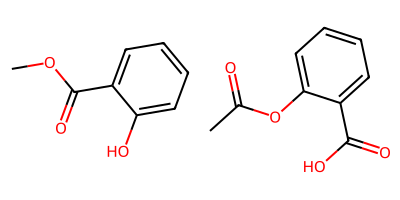

In [ ]:
from rdkit.Chem import Draw

cs = pcp.get_compounds('Aspirin', 'name')
target = cs[0]
print(f"CID: {target.cid}")

props = pcp.get_properties(['CanonicalSMILES', 'IsomericSMILES'], target.cid, 'cid')

smiles = props[0].get('SMILES') # 아스피린 smiles

smiles_list = [
    ex_smiles,
    smiles
]
print(smiles_list)
mols = [Chem.MolFromSmiles(s) for s in smiles_list]
print(mols)
Draw.MolsToGridImage(mols, molsPerRow=2)

In [26]:
for smiles in smiles_list:
    compounds = pcp.get_compounds(smiles, namespace='smiles')

    if compounds:
        compound = compounds[0]
        print(f"CID: {compound.cid}")
        print(f"IUPAC name: {compound.iupac_name}")
        print(f"Synonyms: {compound.synonyms[:5]}")  # 상위 5개만 출력
    else:
        print("No compound found.")

CID: 4133
IUPAC name: methyl 2-hydroxybenzoate
Synonyms: ['methyl salicylate', '119-36-8', 'Methyl 2-hydroxybenzoate', 'Analgit', '2-Hydroxybenzoic acid methyl ester']
CID: 2244
IUPAC name: 2-acetyloxybenzoic acid
Synonyms: ['aspirin', 'ACETYLSALICYLIC ACID', '50-78-2', '2-Acetoxybenzoic acid', '2-(Acetyloxy)benzoic acid']


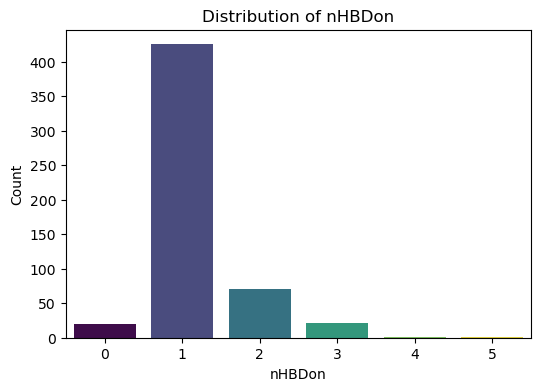

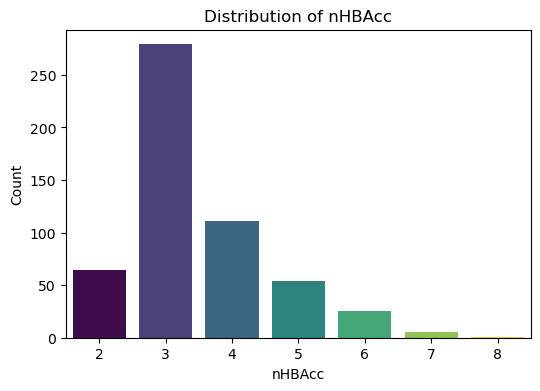

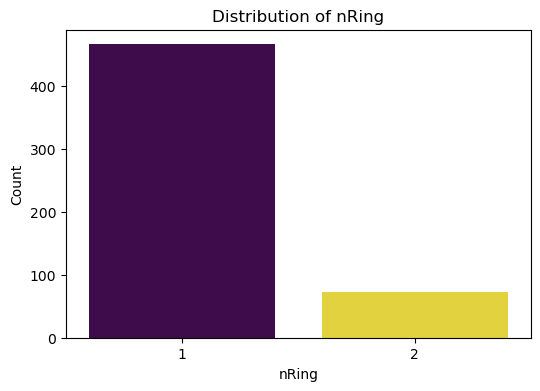

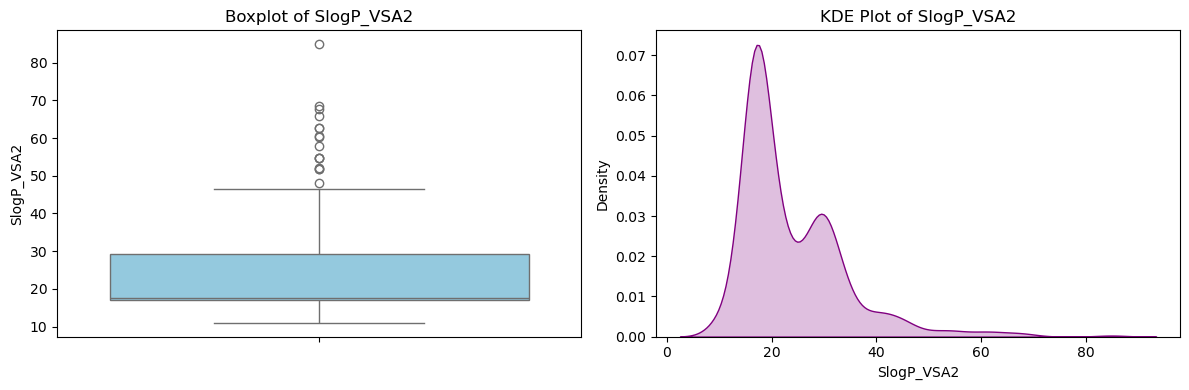

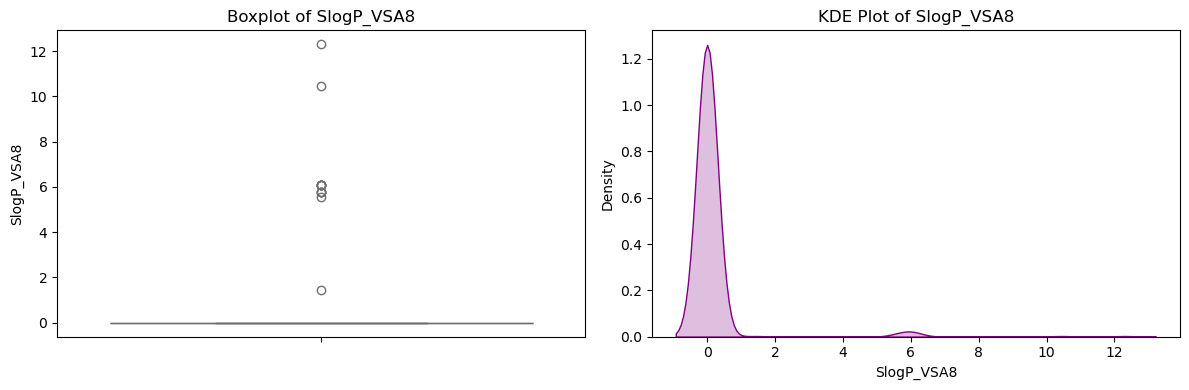

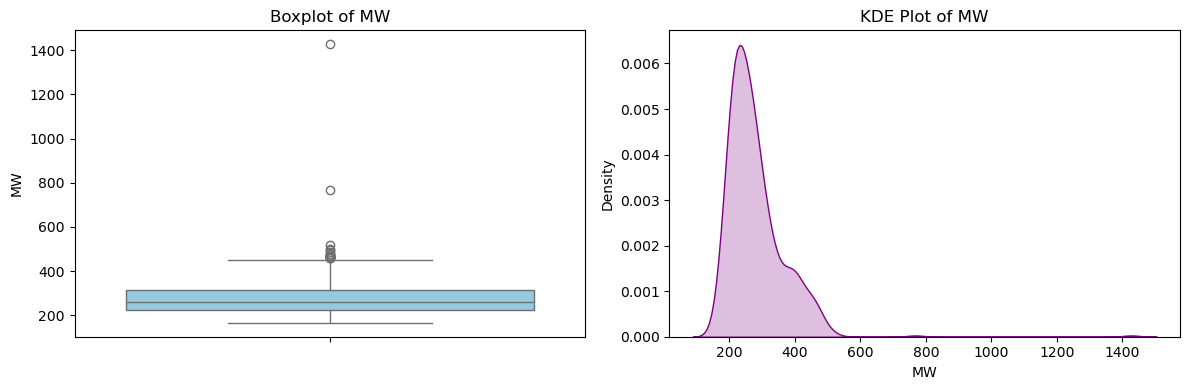

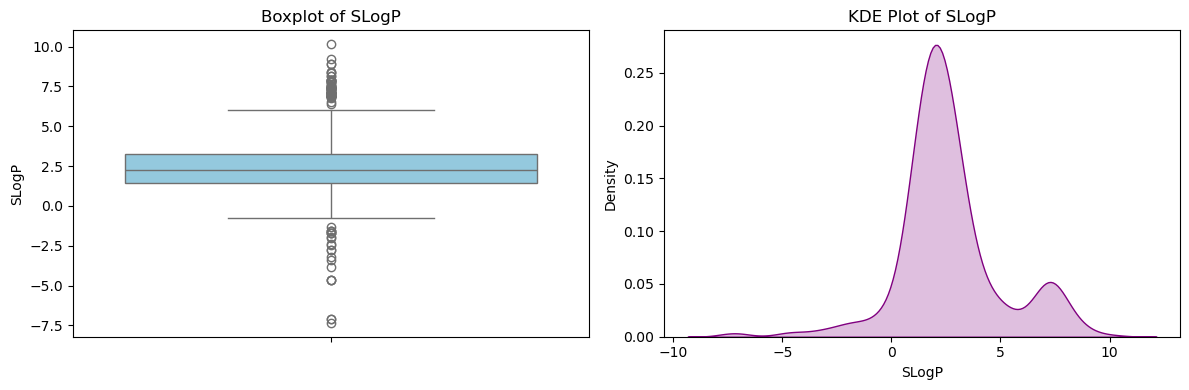

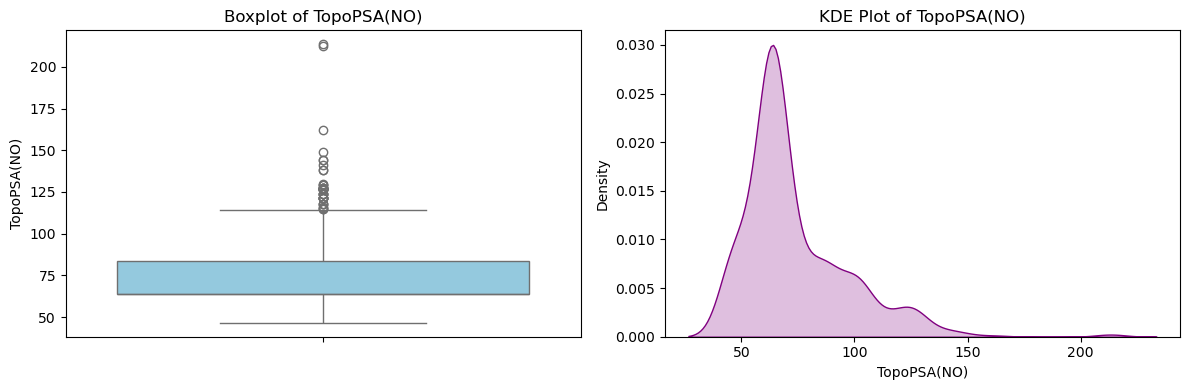

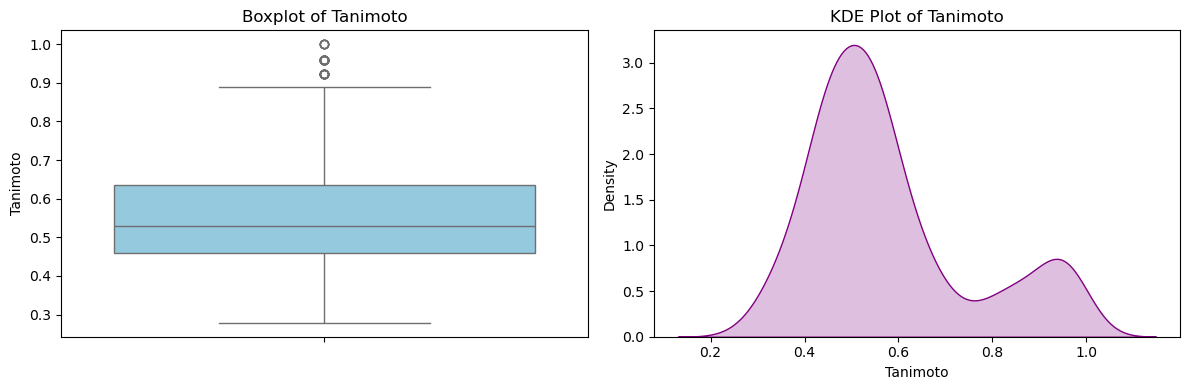

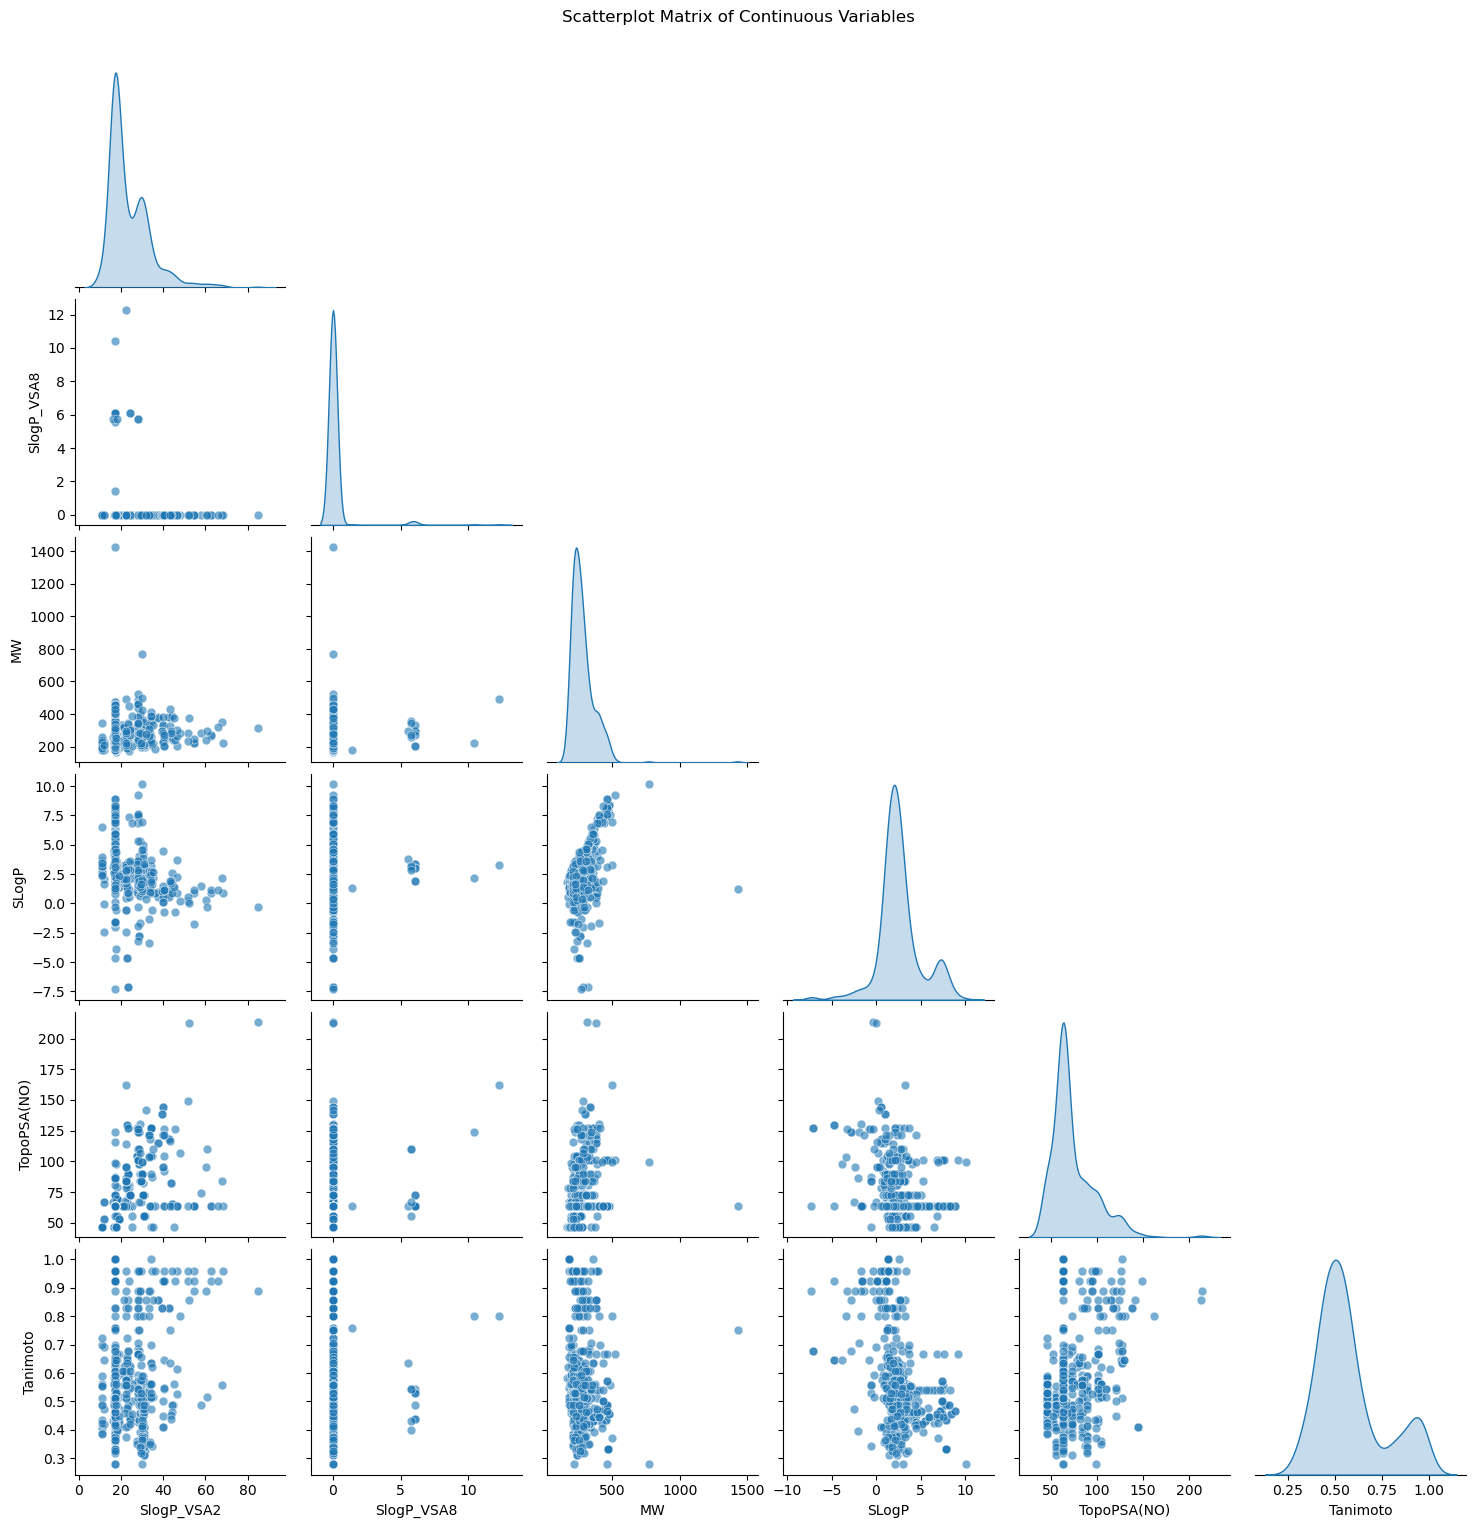

In [77]:
%matplotlib inline
# 이산형 / 연속형 변수 구분
discrete_cols = ['nHBDon', 'nHBAcc', 'nRing']
continuous_cols = ['SlogP_VSA2', 'SlogP_VSA8', 'MW', 'SLogP', 'TopoPSA(NO)', 'Tanimoto']

# ----------------------------
# 1. 이산형 변수 barplot
# ----------------------------
for col in discrete_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue=col, palette='viridis', legend=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

# ----------------------------
# 2. 연속형 변수 boxplot & KDE
# ----------------------------
for col in continuous_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # Boxplot
    sns.boxplot(y=df[col], ax=axes[0], color='skyblue')
    axes[0].set_title(f'Boxplot of {col}')

    # KDE
    sns.kdeplot(df[col], ax=axes[1], fill=True, color='purple')
    axes[1].set_title(f'KDE Plot of {col}')

    plt.tight_layout()
    plt.show()

# ----------------------------
# 3. 연속형 변수끼리 scatterplot matrix
# ----------------------------
sns.pairplot(df[continuous_cols], diag_kind='kde', corner=True,
             plot_kws={'alpha':0.6, 's':40})
plt.suptitle('Scatterplot Matrix of Continuous Variables', y=1.02)
plt.show()